In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import json
import glob
import wandb
import pandas as pd
import seaborn as sns

In [21]:
df = pd.read_parquet('0000.parquet', engine='pyarrow')

22500     0.118612
25000     0.102149
27500     0.096981
30000     0.093290
32500     0.091967
            ...   
190000    0.081342
192500    0.081363
195000    0.082148
197500    0.082821
200000    0.083805
Name: val_loss, Length: 72, dtype: float64


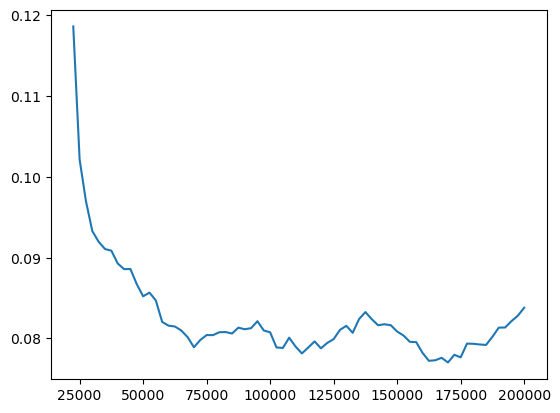

In [22]:
d = df[df["val_loss"].notna()]["val_loss"].rolling(10).mean()
d = d.dropna()
print(d)
x = d.index
y = d.values
plt.plot(x, y)

In [3]:
def get_vals_for_metric(metric, files):
  xs = []
  vals = []
  for f in sorted(files, key=lambda x: int(x.split("/")[-2].split("-")[1])):
    xs.append(int(f.split("/")[-2].split("-")[1]))
    results = json.load(open(f))
    vals.append(results["best_edits"][metric])
  return xs, vals

def get_metrics_for_model(model_name):
  if model_name.endswith(" old"):
    model_name = model_name.replace(" old", "")
    path = f"/home/anton/github/autoseg/src/autoseg/artifacts/{model_name.replace(' ', '_')}/results_old"
  else:
    path = f"/home/anton/github/autoseg/src/autoseg/artifacts/{model_name.replace(' ', '_')}/results"
  #if not glob.glob(path):
  #  path = f"/home/anton/github/autoseg/src/autoseg/artifacts/{model_name.replace(' ', '_')}/results_old"
    
  files = glob.glob(path + "/step-*/result.json")
  for f in files:
    if "step-0" in f:
      files.remove(f)
  print(files)

  xs, merges = get_vals_for_metric("total_merges_needed_to_fix_splits", files)
  _, splits = get_vals_for_metric("total_splits_needed_to_fix_merges", files)
  skel_mods = np.array(merges) + np.array(splits)
  xs = np.array(xs)

  voi_sum = np.array(get_vals_for_metric("voi_sum", files)[1])
  nvi_sum = np.array(get_vals_for_metric("nvi_sum", files)[1])
  path_length = get_vals_for_metric("total path length", files)[1]
  return {
    "checkpoints": xs,
    "merges": merges,
    "splits": splits,
    "skel_mods": skel_mods,
    "skel_splits": get_vals_for_metric("total_splits_needed_to_fix_merges", files)[1],
    "skel_merges": get_vals_for_metric("total_merges_needed_to_fix_splits", files)[1],
    "voi_sum": voi_sum,
    "voi_merge": get_vals_for_metric("voi_merge", files)[1],
    "voi_split": get_vals_for_metric("voi_split", files)[1],
    "nvi_sum": nvi_sum,
    "nvi_merge": get_vals_for_metric("nvi_merge", files)[1],
    "nvi_split": get_vals_for_metric("nvi_split", files)[1],
    "total_path_length": path_length,
    "threshold": get_vals_for_metric("threshold", files)[1],
  }

In [4]:
import pandas as pd
def create_dataframe(models):
  metrics_example = get_metrics_for_model(models[list(models.keys())[0]][0])
  df = pd.DataFrame(columns=["Model Type", "Run", "Run Name"] + list(metrics_example.keys()))
  for group_name, group in models.items():
    for model_i, model in enumerate(group):
      metrics = get_metrics_for_model(model)
      for i, checkpoint in enumerate(metrics["checkpoints"]):
        df.loc[len(df)] = [group_name, model_i, model] + [metrics[key][i] for key in metrics.keys()]
  return df

In [5]:
c = {
  "skel_mods": "Total Edits",
  "checkpoints": "Update Steps",
  "voi_sum": "VOI",
  "nvi_sum": "NVI",
  "normalized_skel_mods": "Normalized Total Edits"
}

In [6]:
graph_conf = {
  #"Baseline UNet Oblique": ["UNet baseline run 1 old", "UNet baseline run 2 old", "UNet baseline run 3 old"],#, "UNet baseline 2"],
  #"Baseline UNet BBCHZ": ["UNet baseline run 1"],#, "UNet baseline run 2 old", "UNet baseline run 3 old"],#, "UNet baseline 2"],
  #"Baseline Unet OSA BBCHZ": ["UNet OSA run 1"],#, "UNet OSA"],
  #"MTLSD UNet": ["UNet LSD 2 run 1", "UNet LSD 2 run 2", "UNet LSD 2 run 3"],#, "UNet LSD 2"],
  #"MTLSD UNet+": ["UNet LSD GELU LayerNorm run 1", "UNet LSD GELU LayerNorm run 2", "UNet LSD GELU LayerNorm run 3"],#, "UNet LSD GELU LayerNorm"], 
  #"UNETR": ["UNETR run 1", "UNETR run 2", "UNETR run 3"],
  "[50, 2, 2]": ["UNet s0"],
  "[50, 4, 4]": ["UNet s1"],
  "[50, 8, 8]": ["UNet s2"],

  #"UNet+ with LSDs": ["UNet LSD GELU LayerNorm run 1", "UNet LSD GELU LayerNorm run 2", "UNet LSD GELU LayerNorm run 3"]
}
baseline = create_dataframe(graph_conf)
baseline["normalized_skel_mods"] = baseline["skel_mods"] / baseline["total_path_length"]
baseline.rename(columns=c, inplace=True)

['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_s0/results/step-75000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_s0/results/step-200000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_s0/results/step-125000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_s0/results/step-150000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_s0/results/step-25000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_s0/results/step-175000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_s0/results/step-50000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_s0/results/step-100000/result.json']
['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_s0/results/step-75000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_s0/results/step-200000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_s0/results/step-125000/resu

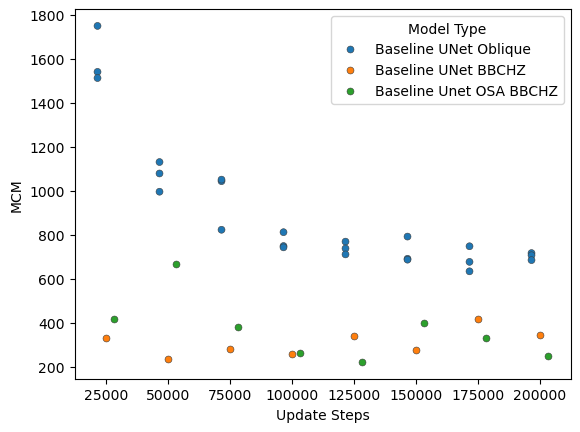

In [8]:
#fig, ax = plt.subplots()
#sns.lineplot(data=baseline, x="checkpoints", y="nvi_sum", hue="Model Type", errorbar=("sd", 0.5), ax=ax)

#sns.stripplot(data=baseline, x=c["checkpoints"], y=c["skel_mods"], hue="Model Type", dodge=True, jitter=0, linewidth=0.4, style="Run")
sns.stripplot(data=baseline, x=c["checkpoints"], y=c["skel_mods"], hue="Model Type", dodge=True, jitter=0, linewidth=0.4)
#sns.lineplot(data=baseline, x=c["checkpoints"], y=c["skel_mods"], hue="Model Type", ci="sd")


#plt.legend(labels=list(graph_conf.keys()))
plt.show()

#sns.swarmplot(data=baseline, x="checkpoints", y="nvi_sum", hue="Model Type", dodge=True)
#sns.lineplot(data=baseline, x="checkpoints", y="nvi_sum", hue="Model Type", errorbar=("sd", 0.5), ax=ax)

#sns.scatterplot(data=baseline, x=c["checkpoints"], y="nvi_sum", hue="Model Type", style="Run")

In [44]:

sns.lineplot(data=baseline, x="checkpoints", y="nvi_sum", hue="Model Type", errorbar=("sd", 0.5), ax=ax)

In [79]:
def agg(group, by):
  return group.agg({
    c["skel_mods"]: by,
    c["voi_sum"]: by,
    c["nvi_sum"]: by
  })

In [90]:
# get best results for each model type, show all metrics, show which update step it was
agg(baseline.groupby("Model Type"), "min").round()
#.agg({c["skel_mods"]: "min", c["voi_sum"]: "min", c["nvi_sum"]: "min"})
#baseline.groupby("Model Type").agg({c["skel_mods"]: "min", c["voi_sum"]: "min", c["nvi_sum"]: "min"})
#baseline.groupby("Model Type").agg({c["skel_mods"]: "min"})

,MCM,VOI,NVI
Model Type,,,
Baseline UNet,634,5.0,0.0
MTLSD UNet,576,5.0,0.0
MTLSD UNet+,585,5.0,0.0


In [147]:
agg(baseline.groupby(["Model Type", c["checkpoints"]]), ["min", "std"]).reset_index()

Model Type Update Steps   MCM                   VOI            \
                                 min         std       min       std   
0   Baseline UNet        25000  1513  129.508044  5.440070  0.064864   
1   Baseline UNet        50000   996   68.090626  5.116370  0.007055   
2   Baseline UNet        75000   823  129.662382  5.076031  0.132946   
3   Baseline UNet       100000   743   38.223030  4.971654  0.026642   
4   Baseline UNet       125000   711   29.022979  4.960838  0.033628   
5   Baseline UNet       150000   687   59.500700  4.936057  0.039111   
6   Baseline UNet       175000   634   57.570247  4.955841  0.016705   
7   Baseline UNet       200000   685   16.370706  4.909641  0.037567   
8      MTLSD UNet        25000  1586  123.757828  5.394836  0.010973   
9      MTLSD UNet        50000   892  132.864593  5.050950  0.049859   
10     MTLSD UNet        75000   744  132.989975  5.051809  0.020929   
11     MTLSD UNet       100000   743   84.124907  4.943203  0.036336   
12     MTLSD UNet       125000   620   98.520725  4.944517  0.037738   
13     MTLSD UNet       150000   576   89.366287  4.936536  0.054244   
14     MTLSD UNet       175000   580   71.121961  4.947386  0.024221   
15     MTLSD UNet       200000   597   92.878056  4.908529  0.048171   
16    MTLSD UNet+        25000  1146   90.500460  5.251619  0.006324   
17    MTLSD UNet+        50000   765  135.308290  5.066379  0.021698   
18    MTLSD UNet+        75000   796   59.340823  5.007714  0.032655   
19    MTLSD UNet+       100000   744   62.793312  4.930123  0.034002   
20    MTLSD UNet+       125000   629   97.257390  4.936472  0.012749   
21    MTLSD UNet+       150000   585  115.170888  4.934449  0.002560   
22    MTLSD UNet+       175000   654  116.431668  4.900820  0.020548   
23    MTLSD UNet+       200000   586  112.280898  4.875521  0.032653   

         NVI            
         min       std  
0   0.505043  0.004089  
1   0.490250  0.000621  
2   0.488029  0.007188  
3   0.482346  0.001516  
4   0.481456  0.002307  
5   0.480513  0.002962  
6   0.481283  0.001532  
7   0.479588  0.001738  
8   0.502336  0.000677  
9   0.487356  0.002507  
10  0.486305  0.002263  
11  0.481666  0.002528  
12  0.480852  0.002193  
13  0.480425  0.002737  
14  0.481400  0.001314  
15  0.478670  0.002551  
16  0.494576  0.001337  
17  0.486361  0.001739  
18  0.482983  0.001509  
19  0.480928  0.002075  
20  0.480990  0.000237  
21  0.479750  0.000996  
22  0.477621  0.002598  
23  0.477141  0.003185

In [174]:
from IPython.display import display, Math, Latex

In [175]:
# At each update step, pick the best model wrt each metric
# Pick the best update step
df = agg(baseline.groupby(["Model Type", c["checkpoints"]]), ["min", "std"]).reset_index()
df = df.iloc[
  df.groupby("Model Type").agg({
      ("MCM", "min"): "idxmin",
    }).values.flatten()
].sort_values(by=("MCM", "min"))
df = df.round({
  ("MCM", "std"): 0, 
  ("VOI", "min"): 3, 
  ("VOI", "std"): 3, 
  ("NVI", "min"): 4, 
  ("NVI", "std"): 4
})
del df["Update Steps"]
print(df.to_latex(index=False, float_format="{0}".format))
df

\begin{tabular}{lrrrrrr}
\toprule
Model Type & \multicolumn{2}{r}{MCM} & \multicolumn{2}{r}{VOI} & \multicolumn{2}{r}{NVI} \\
 & min & std & min & std & min & std \\
\midrule
MTLSD UNet & 576 & 89.0 & 4.937 & 0.054 & 0.4804 & 0.0027 \\
MTLSD UNet+ & 585 & 115.0 & 4.934 & 0.003 & 0.4797 & 0.001 \\
Baseline UNet & 634 & 58.0 & 4.956 & 0.017 & 0.4813 & 0.0015 \\
\bottomrule
\end{tabular}



Model Type  MCM           VOI            NVI        
                   min    std    min    std     min     std
13     MTLSD UNet  576   89.0  4.937  0.054  0.4804  0.0027
21    MTLSD UNet+  585  115.0  4.934  0.003  0.4797  0.0010
6   Baseline UNet  634   58.0  4.956  0.017  0.4813  0.0015

In [159]:

agg(baseline.groupby(["Model Type", c["checkpoints"]]), ["mean", "std"]).reset_index().iloc[
  agg(baseline.groupby(["Model Type", c["checkpoints"]]), ["mean", "std"]).reset_index()
    .groupby("Model Type").agg({
      ("MCM", "mean"): "idxmin",
    }).values.flatten()
].sort_values(by=("MCM", "mean"))

Model Type Update Steps         MCM                   VOI            \
                                      mean         std      mean       std   
14     MTLSD UNet       175000  628.333333   71.121961  4.970670  0.024221   
6   Baseline UNet       175000  686.333333   57.570247  4.973204  0.016705   
21    MTLSD UNet+       150000  706.666667  115.170888  4.937340  0.002560   

         NVI            
        mean       std  
14  0.482686  0.001314  
6   0.482773  0.001532  
21  0.480897  0.000996

In [138]:
idx.flatten()

array([ 6, 13, 21])

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

In [42]:
# display avg and std for each model type
#baseline.groupby(["Model Type", c["checkpoints"]]).agg({c["skel_mods"]: ["mean", "std"], c["voi_sum"]: ["mean", "std"], c["nvi_sum"]: ["mean", "std"]})

In [57]:
import torch
from autoseg.config import read_config
from autoseg.models import Model
def get_num_parameters(config):
  config = read_config(config)
  model = Model(config)
  params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  pretty_params = str(round(params / 1_000_000)) + "M"
  return pretty_params

In [58]:
get_num_parameters("autoseg/user_configs/anton/baselines/unet")

[[1, 27, 27], [1, 9, 9], [1, 3, 3]]


'88M'

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a copy of the dataframe to manipulate the x-values for the strip plot
baseline_copy = baseline.copy()
# Define the width of each category group
width = 0.2
# Calculate the number of categories
num_categories = len(baseline_copy['checkpoints'].unique())
# Create a list to store the adjusted x-values
new_x_values = []

# Iterate over each unique category value
for i, category in enumerate(baseline_copy['checkpoints'].unique()):
    # Calculate the new x-values for the strip plot
    new_x_values.extend([i + width * (j - 0.5) for j in range(num_categories)])

# Add the adjusted x-values to the dataframe
baseline_copy['adjusted_checkpoints'] = new_x_values

# Create the plot
fig, ax = plt.subplots()

# Line plot
sns.lineplot(data=baseline, x="checkpoints", y="skel_mods", hue="Model Type", err_style="bars", ci="sd", ax=ax)

# Strip plot with adjusted x-values
sns.stripplot(data=baseline_copy, x="adjusted_checkpoints", y="skel_mods", hue="Model Type", dodge=True, ax=ax, alpha=0.5)A

plt.show()


ValueError: Length of values (64) does not match length of index (56)

In [27]:
def compare_models(models, metric, scatter=False):
  for model in models:
    avg_metrics = 0
    std = None
    if isinstance(model, list):
      selected_metrics = []
      for model2 in model:
        metrics = get_metrics_for_model(model2)
        selected_metrics.append(metrics[metric])
        if scatter:
          plt.scatter(metrics["checkpoints"], metrics[metric], label=model2)

      selected_metrics = np.array(selected_metrics)
      avg_metrics = np.mean(selected_metrics, axis=0)
      std = np.std(selected_metrics, axis=0)
      checkpoints = metrics["checkpoints"]
      label = model2
      plt.plot(checkpoints, avg_metrics, label=label)
      if std is not None:
        plt.fill_between(checkpoints, avg_metrics - std, avg_metrics + std, alpha=0.3)
      label += " avg"

      best = np.argmin(avg_metrics)
      print(f"Best {metric} for {model2} at checkpoint {checkpoints[best]} with value {avg_metrics[best]} +- {std[best]}")

    else:
      metrics = get_metrics_for_model(model)
      avg_metrics = metrics[metric]
      plt.plot(metrics["checkpoints"], avg_metrics, label=model)
      checkpoints = metrics["checkpoints"]
      label = model

    #plt.plot(metrics["checkpoints"], avg_metrics, label=label)
  plt.title(metric)
  plt.legend()
  plt.show()

['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-75000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-200000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-125000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-150000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-25000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-175000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-50000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-100000/result.json']
['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results_old/step-75000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baselin

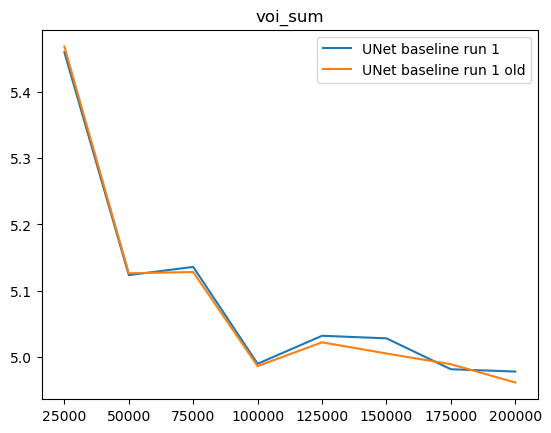

In [28]:
compare_models(["UNet baseline run 1", "UNet baseline run 1 old"], "voi_sum")

['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-75000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-200000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-125000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-150000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-25000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-175000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-50000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-100000/result.json']


[]
[]
['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-75000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-200000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-125000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-150000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-25000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-175000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-50000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-100000/result.json']


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

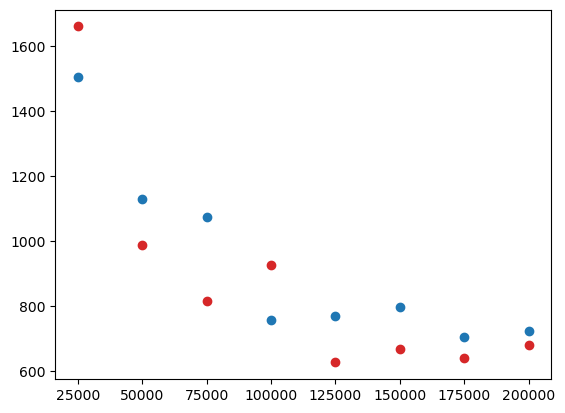

In [29]:
#compare_models(["UNet baseline 2", "UNet LSD 2", "UNet baseline schedule free 2", "UNet LSD GELU LayerNorm"], "voi_sum")
#compare_models(["UNet baseline 2", "UNet LSD 2"], "skel_mods")
#compare_models([["UNet baseline run 1", "UNet baseline run 2", "UNet baseline run 3", "UNet baseline 2"], ["UNet LSD 2 run 1", "UNet LSD 2 run 2", "UNet LSD 2 run 3"]], "skel_mods")
compare_models([["UNet baseline run 1", "UNet baseline run 2", "UNet baseline run 3", "UNet baseline 2"]], "skel_mods", scatter=True)
#compare_models([["UNet LSD 2 run 1", "UNet LSD 2 run 2", "UNet LSD 2 run 3", "UNet LSD 2"]], "skel_mods")
#compare_models(["UNet baseline run 1", "UNet baseline run 2", "UNet baseline run 3", ["UNet baseline run 1", "UNet baseline run 2", "UNet baseline run 3"]], "skel_mods")

['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_2_run_1/results/step-75000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_2_run_1/results/step-200000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_2_run_1/results/step-125000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_2_run_1/results/step-150000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_2_run_1/results/step-25000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_2_run_1/results/step-175000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_2_run_1/results/step-50000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_2_run_1/results/step-100000/result.json']
['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_2_run_2/results/step-75000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_2_run_2/results/step-200000/result

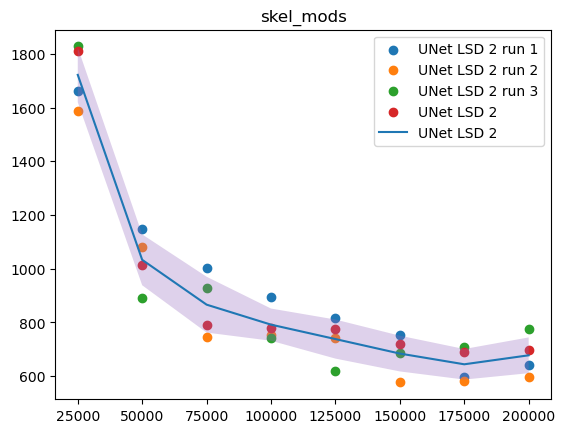

In [ ]:
compare_models([["UNet LSD 2 run 1", "UNet LSD 2 run 2", "UNet LSD 2 run 3", "UNet LSD 2"]], "skel_mods")

['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results_old/step-75000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results_old/step-200000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results_old/step-125000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results_old/step-150000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results_old/step-25000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results_old/step-175000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results_old/step-50000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results_old/step-100000/result.json']
['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_2/results_old/step-75000/result.json', '/home/anton/github/autoseg/sr

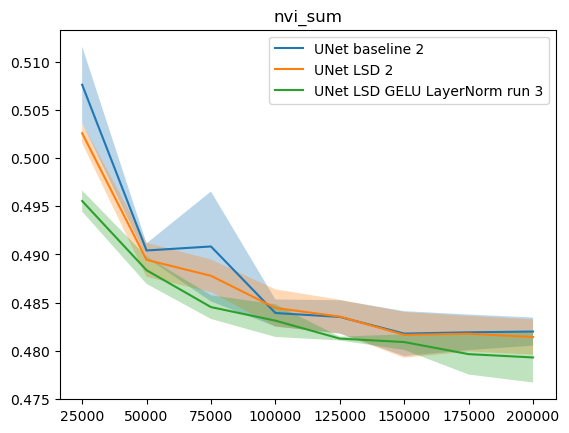

In [ ]:
compare_models([["UNet baseline run 1 old", "UNet baseline run 2 old", "UNet baseline run 3 old", "UNet baseline 2"], ["UNet LSD 2 run 1", "UNet LSD 2 run 2", "UNet LSD 2 run 3", "UNet LSD 2"], ["UNet LSD GELU LayerNorm run 1", "UNet LSD GELU LayerNorm run 2", "UNet LSD GELU LayerNorm run 3"]], "nvi_sum")

['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-75000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-200000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-125000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-150000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-25000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-175000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-50000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_run_1/results/step-100000/result.json']
[]


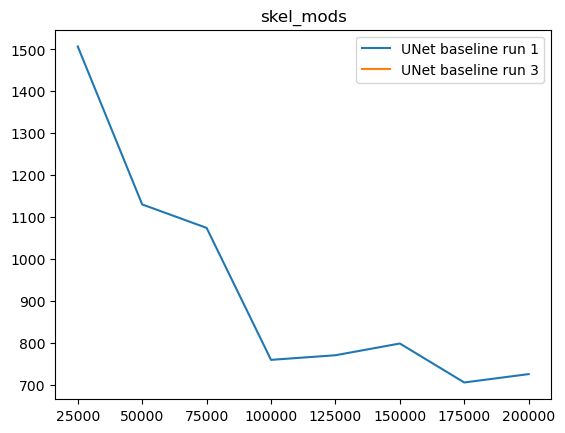

In [ ]:
compare_models(["UNet baseline run 1", "UNet baseline run 3"], "skel_mods", scatter=True)

In [ ]:
get_metrics_for_model("UNet LSD GELU LayerNorm")["skel_mods"]

['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_GELU_LayerNorm/results/step-75000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_GELU_LayerNorm/results/step-200000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_GELU_LayerNorm/results/step-125000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_GELU_LayerNorm/results/step-150000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_GELU_LayerNorm/results/step-25000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_GELU_LayerNorm/results/step-175000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_GELU_LayerNorm/results/step-50000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_LSD_GELU_LayerNorm/results/step-100000/result.json']


array([1427, 1027,  923,  757,  602,  749,  627,  528])

['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-75000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-200000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-125000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-150000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-25000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-175000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-50000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-100000/result.json']
['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-75000/result.json', '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-200000/result.json', '/

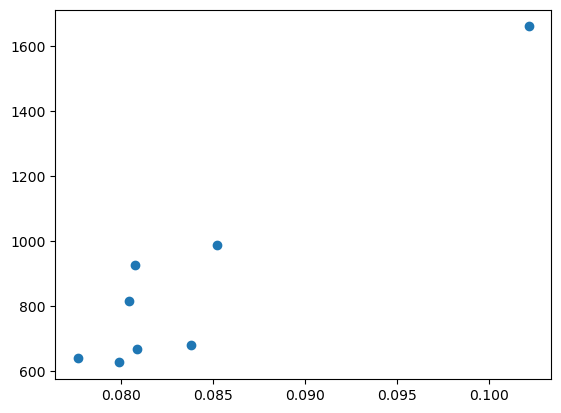

In [ ]:
edits = get_metrics_for_model("UNet baseline 2")["skel_mods"]
its = get_metrics_for_model("UNet baseline 2")["checkpoints"]
loss = d[its]
#plt.plot(loss, edits)

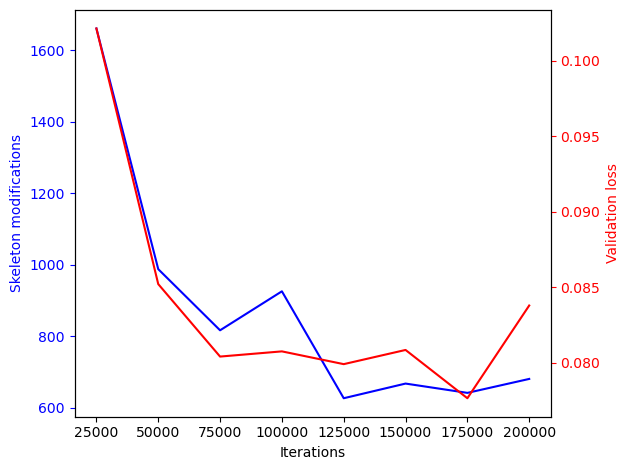

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(its, edits, 'b-')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Skeleton modifications', color='b')
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()
ax2.plot(its, loss, 'r-')
ax2.set_ylabel('Validation loss', color='r')
ax2.tick_params('y', colors='r')
fig.tight_layout()

In [ ]:
#model_name = "UNet LSD 2"
model_name = "UNet baseline 2"

In [ ]:
path = f"/home/anton/github/autoseg/src/autoseg/artifacts/{model_name.replace(' ', '_')}/results"
files = glob.glob(path + "/step-*/result.json")
files

['/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-75000/result.json',
 '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-200000/result.json',
 '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-125000/result.json',
 '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-0/result.json',
 '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-150000/result.json',
 '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-25000/result.json',
 '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-175000/result.json',
 '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-50000/result.json',
 '/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-100000/result.json']

In [ ]:
merges = []
splits = []
checkpoints = []
for f in sorted(files, key=lambda x: int(x.split("/")[-2].split("-")[1])):
  checkpoints.append(f.split("/")[-2].split("-")[1])
  results = json.load(open(f))
  merges.append(results["best_edits"]["total_merges_needed_to_fix_splits"])
  splits.append(results["best_edits"]["total_splits_needed_to_fix_merges"])
  print(f)


/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-0/result.json
/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-25000/result.json
/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-50000/result.json
/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-75000/result.json
/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-100000/result.json
/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-125000/result.json
/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-150000/result.json
/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-175000/result.json
/home/anton/github/autoseg/src/autoseg/artifacts/UNet_baseline_2/results/step-200000/result.json


In [ ]:
(np.array(merges) + np.array(splits))[1:].min()

690

In [ ]:
baseline = np.array(merges) + np.array(splits)

In [ ]:
lsd = np.array(merges) + np.array(splits)

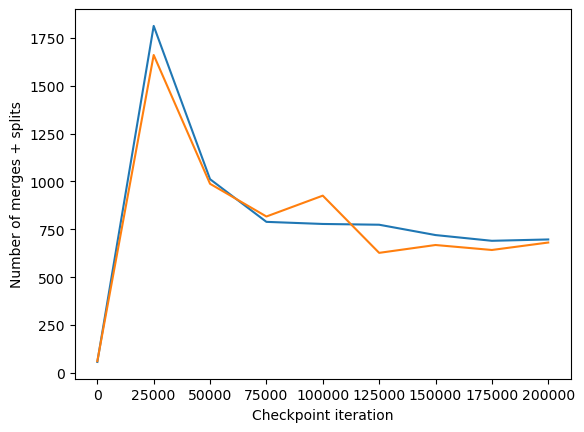

In [ ]:
plt.ylabel("Number of merges + splits")
plt.xlabel("Checkpoint iteration")
#plt.title(model_name)
plt.plot(checkpoints, lsd, label="LSD baseline")
plt.plot(checkpoints, baseline, label="Pure Aff baseline")

In [ ]:
def plot_metric(metric):
  vals = []
  checkpoints = []
  for f in sorted(files, key=lambda x: int(x.split("/")[-2].split("-")[1])):
    checkpoints.append(f.split("/")[-2].split("-")[1])
    results = json.load(open(f))
    vals.append(results["best_nvi"][metric])
  plt.ylabel(metric)
  plt.xlabel("Checkpoint iteration")
  plt.plot(checkpoints, vals)
  

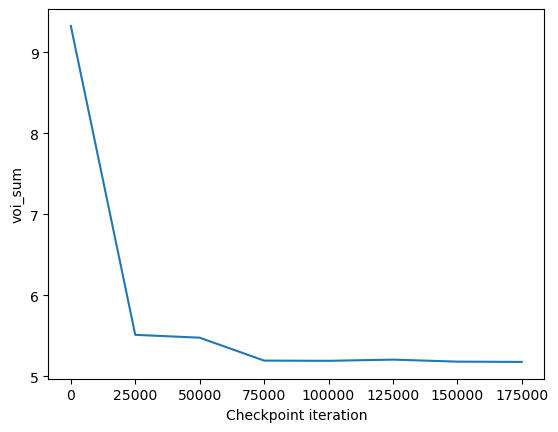

In [ ]:
plot_metric("voi_sum")